## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd

In [2]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')
DATASET_NAME = 'EthereumSentiment'

In [3]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate
api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

2025-01-22 19:32:05,953 - PyTorch version 2.2.2 available.


Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [4]:
result_dict = api_client.eval(dataset=DATASET_NAME,
                              finetune=False)

2025-01-22 19:32:14,495 - Reading data from /Users/lopatenko/Desktop/dev/Fedot.Industrial/fedot_ind/data/EthereumSentiment
2025-01-22 19:32:14,520 - Data read successfully from local folder
2025-01-22 19:32:14,529 - --------------------------------------------------
2025-01-22 19:32:14,530 - Initialising Industrial Repository
2025-01-22 19:32:14,531 - -------------------------------------------------
2025-01-22 19:32:14,531 - Initialising Industrial Evolutionary Optimisation params
2025-01-22 19:32:14,551 - --------------------------------------------------
2025-01-22 19:32:14,551 - Initialising Dask Server
Creating Dask Server
2025-01-22 19:32:14,567 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-01-22 19:32:14,569 - State start
2025-01-22 19:32:14,573 -   Scheduler at: inproc://192.168.1.71/19884/1
2025-01-22 19:32:14,573 -   dashboard at:  http://192.168.1.71:50279/status
2025-01-22 19:32:14,574 - Reg

In [5]:
result_dict['metrics']

,r2,rmse,mae
0,-0.066,0.277,0.223


In [6]:
opt_hist = result_dict['industrial_model'].save(return_history=True)

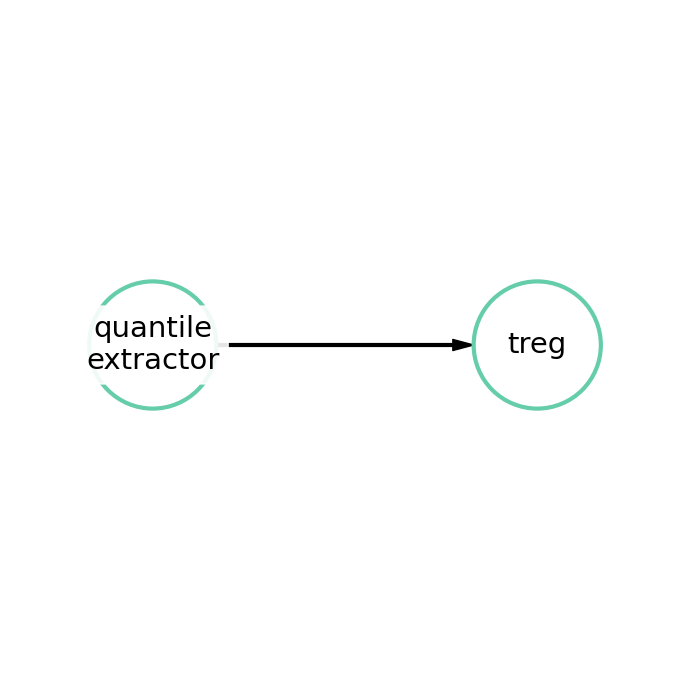

In [7]:
result_dict['industrial_model'].manager.solver.current_pipeline.show()

In [8]:
opt_hist = result_dict['industrial_model'].vis_optimisation_history(opt_history_path=opt_hist,
                                                                    mode='fitness',
                                                                    return_history=True)

AttributeError: 'NoneType' object has no attribute 'generations'

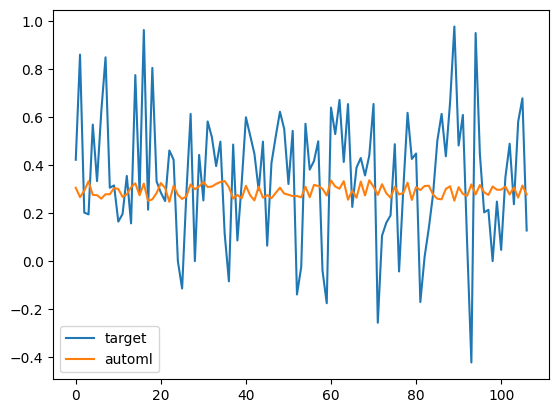

In [10]:
from matplotlib import pyplot as plt
import numpy as np

predictions = np.vstack([api_client.test_data[1].flatten(),result_dict['labels'].flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','automl'])
all_prediction.plot()
plt.show()

In [12]:
result_dict['industrial_model'].manager.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,2
Data Preprocessing,0,0,0,0,0
Fitting (summary),0,0,0,8,717
Composing,0,0,0,8,617
Train Inference,0,0,0,0,0
Tuning (composing),0,0,0,0,0
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,0
Predicting,0,0,0,2,829


## Compare with State of Art (SOTA) models

In [13]:
from fedot_ind.tools.serialisation.path_lib import PROJECT_PATH
df = pd.read_csv(PROJECT_PATH + '/benchmark/ts_regression_sota_results.csv', sep=';')
df = df[df['ds/type'] == DATASET_NAME].iloc[:, :25]
df.index = df['algorithm']
df = df.drop(['algorithm', 'ds/type'], axis=1)
df = df.replace(',', '.', regex=True).astype(float)

In [14]:
df['Fedot_Industrial_AutoML'] = result_dict['metrics']['rmse'][0]
df = df.T

In [15]:
df.sort_values('min')['min']

FreshPRINCE_RMSE           0.180515
DrCIF_RMSE                 0.180643
RotF_RMSE                  0.187496
RandF_RMSE                 0.193914
FPCR_RMSE                  0.195632
TSF_RMSE                   0.200847
FPCR-Bs_RMSE               0.201391
5NN-DTW_RMSE               0.205914
RDST_RMSE                  0.208743
Ridge_RMSE                 0.213185
5NN-ED_RMSE                0.215282
RIST_RMSE                  0.222417
FCN_RMSE                   0.222711
XGBoost_RMSE               0.224208
ResNet_RMSE                0.224795
InceptionT_RMSE            0.224887
MultiROCKET_RMSE           0.224921
SingleInception_RMSE       0.226110
Grid-SVR_RMSE              0.227387
CNN_RMSE                   0.234338
1NN-DTW_RMSE               0.255744
ROCKET_RMSE                0.257576
1NN-ED_RMSE                0.267144
Fedot_Industrial_AutoML    0.277000
Name: min, dtype: float64

In [16]:
df.sort_values('max')['max']

DrCIF_RMSE                 0.256310
RIST_RMSE                  0.256706
RandF_RMSE                 0.257411
RDST_RMSE                  0.257594
FreshPRINCE_RMSE           0.260502
RotF_RMSE                  0.263084
5NN-ED_RMSE                0.264245
FPCR_RMSE                  0.268228
5NN-DTW_RMSE               0.268344
TSF_RMSE                   0.269265
FPCR-Bs_RMSE               0.276976
Fedot_Industrial_AutoML    0.277000
XGBoost_RMSE               0.281631
InceptionT_RMSE            0.288174
Grid-SVR_RMSE              0.290551
MultiROCKET_RMSE           0.291900
FCN_RMSE                   0.295570
SingleInception_RMSE       0.296679
ResNet_RMSE                0.302419
Ridge_RMSE                 0.314523
ROCKET_RMSE                0.319622
CNN_RMSE                   0.348164
1NN-ED_RMSE                0.427555
1NN-DTW_RMSE               0.435497
Name: max, dtype: float64

In [17]:
df.sort_values('average')['average']

DrCIF_RMSE                 0.223448
FreshPRINCE_RMSE           0.225876
RotF_RMSE                  0.229423
FPCR_RMSE                  0.231336
RandF_RMSE                 0.233020
TSF_RMSE                   0.234477
FPCR-Bs_RMSE               0.235169
RDST_RMSE                  0.239879
RIST_RMSE                  0.241129
5NN-DTW_RMSE               0.241217
5NN-ED_RMSE                0.246046
MultiROCKET_RMSE           0.249028
InceptionT_RMSE            0.251960
XGBoost_RMSE               0.252351
FCN_RMSE                   0.252702
ResNet_RMSE                0.255854
Grid-SVR_RMSE              0.257539
SingleInception_RMSE       0.257753
Ridge_RMSE                 0.262168
CNN_RMSE                   0.271610
Fedot_Industrial_AutoML    0.277000
ROCKET_RMSE                0.287077
1NN-DTW_RMSE               0.318791
1NN-ED_RMSE                0.333878
Name: average, dtype: float64